### Python Implementation of Modern Portfolio Theory

This code relates to my article on Medium.

For any questions, please leave a comment on the article or here on Github.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

In [11]:
data = pd.read_csv('resources/CAPM_data.csv').set_index('Date')
data = data.drop(columns=['dia'], axis=1)
data = data[::-1]

daily_returns = data.pct_change()*100
daily_returns = daily_returns.dropna()

mus = daily_returns.mean()
cov = returns.cov()
var = returns.var()

daily_returns.head()

,IBEX,ABE,BBVA,ELE,ENG,GRF,IDX,SAN,TEF
Date,,,,,,,,,
04/10/10,-0.331990,-0.881057,-1.025641,-1.081359,-1.235415,-0.381316,-2.560530,0.109890,-0.715072
05/10/10,3.097896,1.481481,3.419689,1.093181,1.459347,0.287081,2.878084,3.951701,2.271468
06/10/10,0.378827,0.875912,0.000000,0.102987,-0.753425,0.381679,-0.938315,0.211193,0.270856
07/10/10,0.808268,0.217077,-0.501002,0.771605,1.656315,0.000000,2.560954,0.210748,1.080497
08/10/10,-0.112209,0.505415,-0.302115,0.306279,-0.407332,1.235741,-0.495981,-1.051525,0.267237


,AAPL,JPM,WMT,TGT,MSFT,AMGN
2000-01-03,0.088754,-0.061947,-0.033454,-0.018723,-0.001606,0.047867
2000-01-04,-0.084310,-0.027444,-0.037418,-0.043365,-0.033780,-0.076465
2000-01-05,0.014634,-0.006173,-0.020408,-0.022665,0.010544,0.034409
2000-01-06,-0.086538,0.014197,0.010913,-0.047310,-0.033498,0.016632
2000-01-07,0.047368,0.018373,0.075564,0.051607,0.013068,0.112474


In [21]:
daily_returns = pd.read_csv('daily_returns.csv', index_col=0)

#-- Get annualised mean returns - https://quant.stackexchange.com/questions/4753/annualized-covariance
mus = (1+daily_returns.mean())**252 - 1
cov = daily_returns.cov()*252
daily_returns.head()

,AAPL,JPM,WMT,TGT,MSFT,AMGN
2000-01-03,0.088754,-0.061947,-0.033454,-0.018723,-0.001606,0.047867
2000-01-04,-0.084310,-0.027444,-0.037418,-0.043365,-0.033780,-0.076465
2000-01-05,0.014634,-0.006173,-0.020408,-0.022665,0.010544,0.034409
2000-01-06,-0.086538,0.014197,0.010913,-0.047310,-0.033498,0.016632
2000-01-07,0.047368,0.018373,0.075564,0.051607,0.013068,0.112474


### Create Random Portfolios

In [22]:
#- How many assests to include in each portfolio
n_assets = 5
#-- How many portfolios to generate
n_portfolios = 1000

#-- Initialize empty list to store mean-variance pairs for plotting
mean_variance_pairs = []

np.random.seed(75)
#-- Loop through and generate lots of random portfolios
for i in range(n_portfolios):
    #- Choose assets randomly without replacement
    assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
    #- Choose weights randomly
    weights = np.random.rand(n_assets)
    #- Ensure weights sum to 1
    weights = weights/sum(weights)

    #-- Loop over asset pairs and compute portfolio return and variance
    #- https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie
    portfolio_E_Variance = 0
    portfolio_E_Return = 0
    for i in range(len(assets)):
        portfolio_E_Return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            #-- Add variance/covariance for each asset pair
            #- Note that when i==j this adds the variance
            portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    #-- Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
    


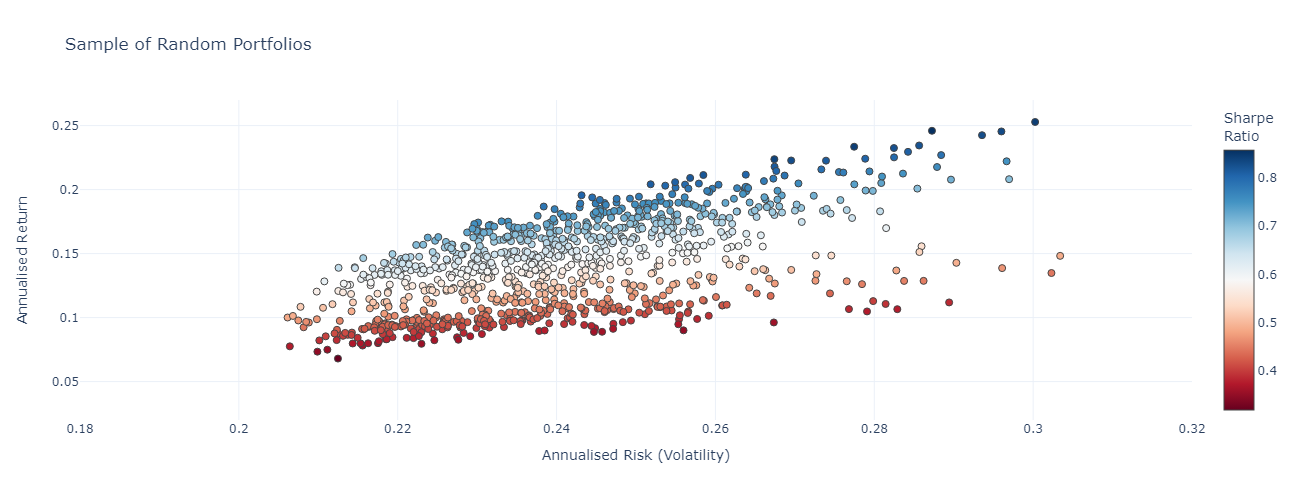

In [23]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.32])
fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

### Sample only from efficient frontier

In [24]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 5

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3340.39it/s]


In [25]:
len(mean_variance_pairs)

237

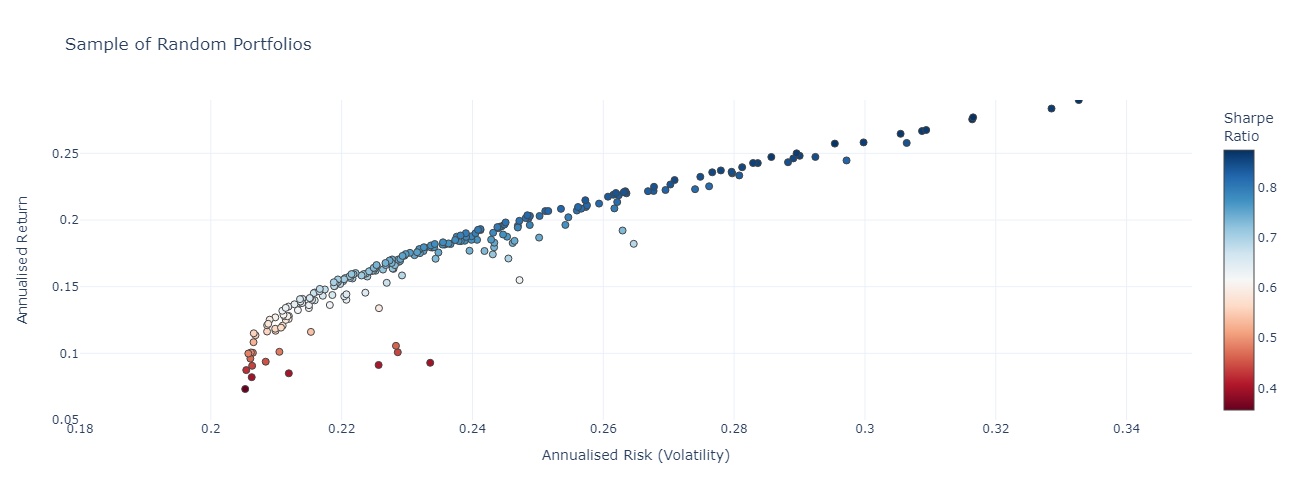

In [26]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))